In [1]:
from pyspark import SparkConf, SparkContext
import datetime
from math import acos, sin, cos, floor
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_shortest_distance(lat1, lon1, lat2, lon2):
    return acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon2 - lon1)) * 6371

In [3]:
def parse_table1(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, 1)

In [4]:
def parse_table2(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    V_AVG = 12/3.6/1000
    startt = datetime.datetime.strptime(startt, '%Y-%m-%dT%H:%M:%S')
    endt = datetime.datetime.strptime(endt, '%Y-%m-%dT%H:%M:%S')
    duration = endt - startt
    #return (bikeid, get_shortest_distance(int(startlt), int(startln), int(endlt), int(endln))) через координаты
    return (bikeid, V_AVG*duration.total_seconds())

In [5]:
def parse_table3(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, startt[0:7])

In [6]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)

23/04/11 22:36:14 WARN Utils: Your hostname, bigdata resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/04/11 22:36:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/11 22:36:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
REPAIR_LIM = 10000
REPAIR_PRICE = 60
eREPAIR_PRICE = 80
BIKE_PRICE = 1500
eBIKE_PRICE = 2000

In [8]:
unique_by_year = []
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table1) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .map(lambda x: (None, 1)) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .collect()
    unique_by_year.append((y, df[0][1]))
print("Уникальные велосипеды по годам:", unique_by_year)

Уникальные велосипеды по годам: [(2013, 2887), (2014, 2968), (2015, 4724), (2016, 5543), (2017, 5899), (2018, 6133), (2019, 6017)]


In [11]:
cum_repairs = []
run = []
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table2) \
                                          .reduceByKey(lambda a, b: a + b)
    big = big.union(df)
    analyse_rep = big.map(lambda x: (None, floor(x[1] / REPAIR_LIM))) \
                 .reduceByKey(lambda a, b: a + b) \
                 .collect()
    cum_repairs.append((y, analyse_rep[0][1]))
    analyse_run = df.map(lambda x: (None, x[1])) \
                    .reduceByKey(lambda a, b: a + b) \
                    .collect()
    run.append((y, analyse_run[0][1]))
print("Накопительное количество ремонтов по годам: ", cum_repairs)
print("Пробег по годам: ", run)

Накопительное количество ремонтов по годам:  [(2013, 0), (2014, 0), (2015, 0), (2016, 0), (2017, 0), (2018, 179), (2019, 358)]
Пробег по годам:  [(2013, 3138680.999999999), (2014, 8386190.199999998), (2015, 10866616.600000001), (2016, 4758674.199999999), (2017, 1738613.9999999995), (2018, 16972177.416666664), (2019, 18459430.796666663)]


In [19]:
cum = 0
repairs = []
for y, s in cum_repairs:
    repairs.append((y, s - cum))
    cum = s
print("Количество ремонтов по годам: ", repairs)
repair_prices = [(y, x * 0.6 * eREPAIR_PRICE + x * 0.4 * REPAIR_PRICE) for y, x in repairs]
print("Затраты на ремонт по годам: ", repair_prices)
print("Средние затраты по годам: ", sum([x for y, x in repair_prices]) / len(list(filter(lambda x: x[1] != 0, repair_prices))))

Количество ремонтов по годам:  [(2013, 0), (2014, 0), (2015, 0), (2016, 0), (2017, 0), (2018, 179), (2019, 179)]
Затраты на ремонт по годам:  [(2013, 0.0), (2014, 0.0), (2015, 0.0), (2016, 0.0), (2017, 0.0), (2018, 12888.0), (2019, 12888.0)]
Средние затраты по годам:  12888.0


In [13]:
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table3)
    big = big.union(df)

unique = big.reduceByKey(lambda a, b: a if a < b else b) \
            .map(lambda x: (x[1], 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .collect()
unique_by_year2 = []
for y in range(2013, 2019 + 1):
    summa = 0
    for d, x in unique:
        if str(y) in d:
            summa += x
    unique_by_year2.append((y, summa))
print("Новые уникальные велосипеды по месяцам:", unique)
print("Новые уникальные велосипеды по годам:", unique_by_year2)
avg_bike = sum([x for y, x in unique_by_year2]) / len(unique_by_year2)
print("Среднее новых по годам: ", avg_bike)
print("Средние затраты на велосипеды: ", avg_bike * 0.6 * eBIKE_PRICE + avg_bike * 0.4 * BIKE_PRICE)

Новые уникальные велосипеды по месяцам: [('2013-10', 345), ('2018-07', 2), ('2014-09', 2), ('2013-08', 755), ('2013-12', 66), ('2018-11', 1), ('2015-05', 1200), ('2015-07', 4), ('2013-09', 722), ('2018-05', 1), ('2013-11', 12), ('2015-01', 1), ('2016-06', 694), ('2015-03', 3), ('2016-05', 205), ('2014-10', 3), ('2014-03', 65), ('2015-08', 3), ('2017-10', 682), ('2014-05', 28), ('2018-10', 1), ('2014-04', 3), ('2013-07', 389), ('2017-12', 6), ('2013-06', 598), ('2015-06', 40), ('2019-11', 139), ('2018-01', 5), ('2014-01', 3), ('2018-06', 1), ('2017-11', 22), ('2015-04', 517)]
Новые уникальные велосипеды по годам: [(2013, 2887), (2014, 104), (2015, 1768), (2016, 899), (2017, 710), (2018, 11), (2019, 139)]
Среднее новых по годам:  931.1428571428571
Средние затраты на велосипеды:  1676057.1428571427


Text(0.5, 0, 'Год')

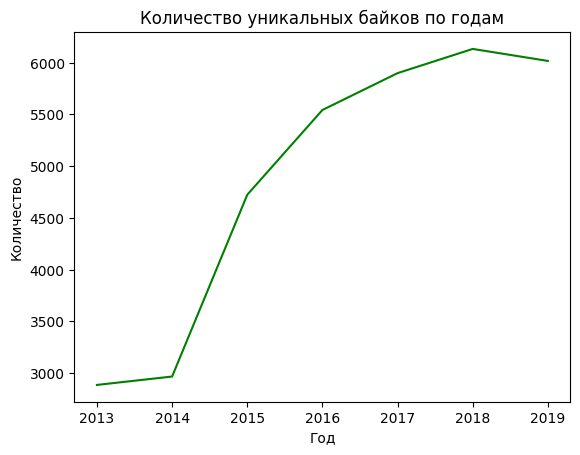

In [14]:
pdf = pd.DataFrame(unique_by_year)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Количество уникальных байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

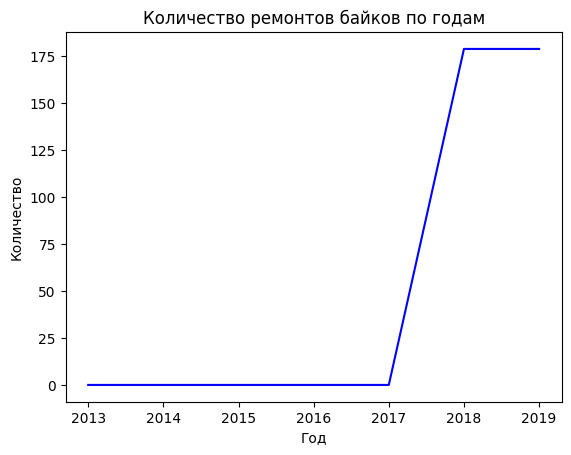

In [15]:
pdf = pd.DataFrame(repairs)
plt.plot(pdf[0], pdf[1], c="blue")
plt.title("Количество ремонтов байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

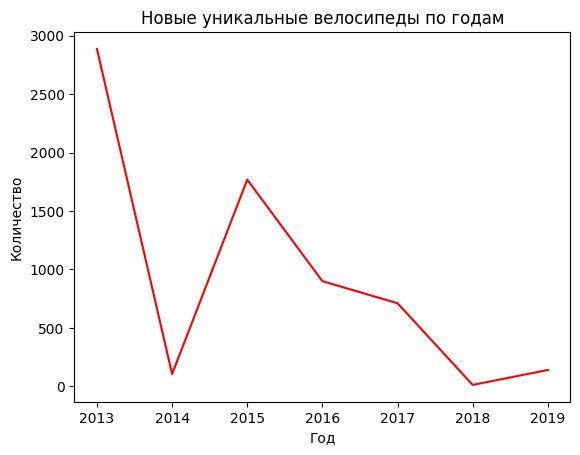

In [16]:
pdf = pd.DataFrame(unique_by_year2)
plt.plot(pdf[0], pdf[1], c="red")
plt.title("Новые уникальные велосипеды по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

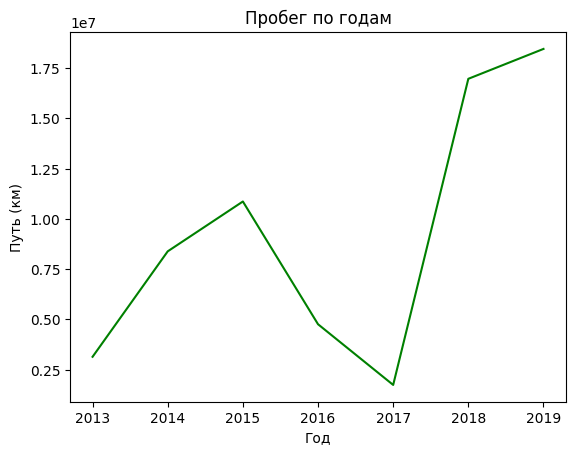

In [17]:
pdf = pd.DataFrame(run)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Пробег по годам")
plt.ylabel("Путь (км)")
plt.xlabel("Год")

Какие выводы можно сделать из графиков за 2013-2019 года?
1. Велосипедная сеть росла, лишь в 2019 году наблюдается незначительный спад количества уникальных байков
2. В 2016 наблюдается небольшой спад пользования сети (подтверждение о чем можно найти в новостных лентах)
3. График ремонта байков будет цикличен. Divvy основан в 2013 году, в этом году введена большая часть велосипедов этой сети (вторая часть была введена в эксплуатацию после расширения сети в 2015 году). Значит, по истечении 2-х лет количество ремонтов байков достигнет пика, затем снова пойдет спад. В 2018 году идет наложение ремонта сразу двух "подгрупп" велосипедов (2013 + 2015) => Нужно вводить велосипеды в использование равномерно?